In [1]:
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

In [2]:
df = quandl.get('WIKI/GOOGL')
df2 = quandl.get('WIKI/GOOGL')

In [3]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In machine learning the columns are called 'features'. We want meaningfull features especially for linear regression. LR is not super depth so the corellations between features have to be passed by us and base on that it will make predictions.

In [4]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [5]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

In [6]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


Features are attributes that make up the label and the label is some sort of prediction into the future.

In [7]:
df.isna().sum()

Adj. Close     0
HL_PCT         0
PCT_change     0
Adj. Volume    0
dtype: int64

We do not want missing values and sometimes the best approach to this is to fill them with outliers.

In [8]:
df.fillna(-9999, inplace=True)

In [9]:
forecast_col = 'Adj. Close' # column that we are making predictions on

In [10]:
forecast_out = int(math.ceil(0.01 * len(df))) # 1% of days (rows), approx 35 days into the future

In [11]:
df.tail(50)

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2018-01-16,1130.70,1.607854,-0.842753,1783881.0
2018-01-17,1139.10,0.019313,0.241121,1353097.0
2018-01-18,1135.97,0.406701,-0.296660,1333633.0
2018-01-19,1143.50,0.024486,0.480655,1418376.0
2018-01-22,1164.16,0.233645,1.778252,1437954.0
2018-01-23,1176.17,0.198951,0.474108,1832126.0
2018-01-24,1171.29,1.345525,-1.155294,1818182.0
2018-01-25,1182.14,0.241934,0.121114,1398961.0
2018-01-26,1187.56,0.000000,0.002526,1981476.0


In [12]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [13]:
df.tail(50)

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2018-01-16,1130.70,1.607854,-0.842753,1783881.0,1115.04
2018-01-17,1139.10,0.019313,0.241121,1353097.0,1129.38
2018-01-18,1135.97,0.406701,-0.296660,1333633.0,1160.84
2018-01-19,1143.50,0.024486,0.480655,1418376.0,1165.93
2018-01-22,1164.16,0.233645,1.778252,1437954.0,1139.91
2018-01-23,1176.17,0.198951,0.474108,1832126.0,1148.89
2018-01-24,1171.29,1.345525,-1.155294,1818182.0,1150.61
2018-01-25,1182.14,0.241934,0.121114,1398961.0,1134.42
2018-01-26,1187.56,0.000000,0.002526,1981476.0,1100.07


In [14]:
df.isna().sum()

Adj. Close      0
HL_PCT          0
PCT_change      0
Adj. Volume     0
label          35
dtype: int64

Label is like our end goal?

In [15]:
df.isna().sum()

Adj. Close      0
HL_PCT          0
PCT_change      0
Adj. Volume     0
label          35
dtype: int64

Features are 'X' and labels are 'y'

In [16]:
X = np.array(df.drop(['label'], axis=1))
print(X)

[[ 5.03228418e+01  3.71256291e+00  3.24967503e-01  4.46590000e+07]
 [ 5.43226889e+01  7.10922353e-01  7.22700723e+00  2.28343000e+07]
 [ 5.48693765e+01  3.72943327e+00 -1.22788010e+00  1.82561000e+07]
 ...
 [ 1.02655000e+03  3.91895183e+00 -2.36072933e+00  2.41351700e+06]
 [ 1.05409000e+03  4.91419139e-01  3.32191129e-01  3.27240900e+06]
 [ 1.00694000e+03  5.72030111e+00 -5.35388664e+00  2.94095700e+06]]


In [17]:
X = preprocessing.scale(X) # in that it would subtract the mean of your points first, then divide by the standard deviation
print(X[-36])

[ 2.55960556  2.87565464 -1.90605746 -0.49425191]


In [18]:
X_lately = X[-forecast_out:] # last 35 rows, this is the stuff that we are gonna predcit about
print(X_lately)

[[ 2.62040424 -0.69832022  3.25839716 -0.49545744]
 [ 2.50780834  1.66160318 -1.79354019 -0.6394908 ]
 [ 2.31454846  4.17610055 -3.38541422 -0.57613569]
 [ 2.46132664 -0.23766898  1.15324503 -0.41015315]
 [ 2.50451039 -0.01764958 -0.11604074 -0.60898579]
 [ 2.50288082 -0.34599149  0.27859553 -0.75717739]
 [ 2.57489253 -0.71049234  1.17488957 -0.70190181]
 [ 2.64729224 -0.71680879  0.50169569 -0.72903566]
 [ 2.66335519  0.09281915  0.14545442 -0.70894085]
 [ 2.69474392  0.07647313  0.67510086 -0.74841251]
 [ 2.73416412  0.8390688   0.2951878  -0.70256205]
 [ 2.71922635  0.29789985 -0.53369123 -0.77997427]
 [ 2.78980248 -0.8670452   0.57670541 -0.79835378]
 [ 2.85036837 -0.89962333  0.71164132 -0.76748452]
 [ 2.7487527   1.17156108 -1.50481437 -0.69403423]
 [ 2.6960243   0.95712701 -1.05399713 -0.65327277]
 [ 2.5698874   2.34201725 -2.26663627 -0.61255097]
 [ 2.61927906 -0.71452134  1.65946178 -0.64392126]
 [ 2.66048404 -0.42111838  1.04146504 -0.77436569]
 [ 2.68430688 -0.55935131 -0.05

In [19]:
X = X[:-forecast_out] # every till last 35 rows
print(X)

[[-1.39187095  2.33516806  0.23254018  4.46712802]
 [-1.37635178 -0.31135438  4.81828847  1.8207495 ]
 [-1.37423066  2.35004252 -0.79917922  1.26561472]
 ...
 [ 2.99737935 -0.50090092  0.33301614 -0.61156746]
 [ 2.7553098   0.01505419 -0.46778619 -0.24489949]
 [ 2.55960556  2.87565464 -1.90605746 -0.49425191]]


In [20]:
df.dropna(inplace=True)

In [21]:
y = np.array(df['label'])
print(y)

[  69.0782379    67.83941377   68.91272699 ... 1026.55       1054.09
 1006.94      ]


In [22]:
df.describe()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
count,3389.000000,3389.000000,3389.000000,3.389000e+03,3389.000000
mean,401.979869,1.059370,-0.022334,7.875811e+06,412.689425
std,249.427375,1.129061,1.497566,8.270999e+06,256.598265
min,50.159839,0.000000,-9.179757,5.211410e+05,67.839414
25%,230.260793,0.335286,-0.739860,2.466700e+06,233.094541
50%,298.461322,0.725560,-0.016783,5.121752e+06,301.425472
75%,557.510000,1.382842,0.751792,1.039790e+07,563.390000
max,1187.560000,11.157480,8.759770,8.215110e+07,1187.560000


In [23]:
X

array([[-1.39187095,  2.33516806,  0.23254018,  4.46712802],
       [-1.37635178, -0.31135438,  4.81828847,  1.8207495 ],
       [-1.37423066,  2.35004252, -0.79917922,  1.26561472],
       ...,
       [ 2.99737935, -0.50090092,  0.33301614, -0.61156746],
       [ 2.7553098 ,  0.01505419, -0.46778619, -0.24489949],
       [ 2.55960556,  2.87565464, -1.90605746, -0.49425191]])

In [24]:
len(X), len(y) # make sure they are equal len

(3389, 3389)

In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [26]:
classifier = LinearRegression()
classifier.fit(X_train, y_train) # fit for training data

LinearRegression()

In [27]:
with open('linearregression.pickle', 'wb') as f: # saving classifier with pickle to avoid training it again
    pickle.dump(classifier, f)

In [28]:
accuracy = classifier.score(X_test, y_test) # score for test data

Why do we want to train and test on separated data? Because if we train classifier on the same data that we are testing, it will already know the answers so it does not make any sense.

In [29]:
print(f'{accuracy * 100:.2f}%')

97.77%


In [30]:
print(forecast_out)

35


What if we want to use different algorithm?

In [31]:
classifier_svm = svm.SVR()
classifier_svm.fit(X_train, y_train) # fit for training data
accuracy_svm = classifier_svm.score(X_test, y_test) # score for test data

In [32]:
print(f'{accuracy_svm * 100:.2f}%')

80.02%


We can use many cpu threads with some algortihms like linear regression for example. n_jobs parameter defines it. It affects the training part a lot, it can speed it up. n_jobs=-1 runs as much threads as our processor can handle.

In [33]:
forecast_set = classifier.predict(X_lately) # we can pass single value or an array

In [34]:
forecast_set

array([1103.48303793, 1072.66194692, 1020.37422253, 1061.3678911 ,
       1072.97479954, 1073.26728009, 1092.1395614 , 1111.00717326,
       1114.54655256, 1122.88575766, 1132.44951949, 1129.1090588 ,
       1148.39676997, 1164.08512024, 1135.85338193, 1122.19171659,
       1088.22662996, 1103.54264349, 1114.42144181, 1120.72641092,
       1135.1597429 , 1149.54579878, 1181.22131871, 1185.62547899,
       1157.85626001, 1168.5375255 , 1170.36745516, 1152.98003422,
       1118.29911089, 1114.7143808 , 1112.91851135, 1070.07817561,
       1043.02774655, 1072.67694895, 1021.81026273])

In [35]:
style.use('ggplot')

In [36]:
df['Forecast'] = np.nan

In [37]:
last_date = df.iloc[-1].name # because date is in our name (index)

In [38]:
last_unix = last_date.timestamp() # in unix-style time

In [39]:
one_day = 86400

In [40]:
next_unix = last_unix + one_day

In [41]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

<AxesSubplot:xlabel='Date'>

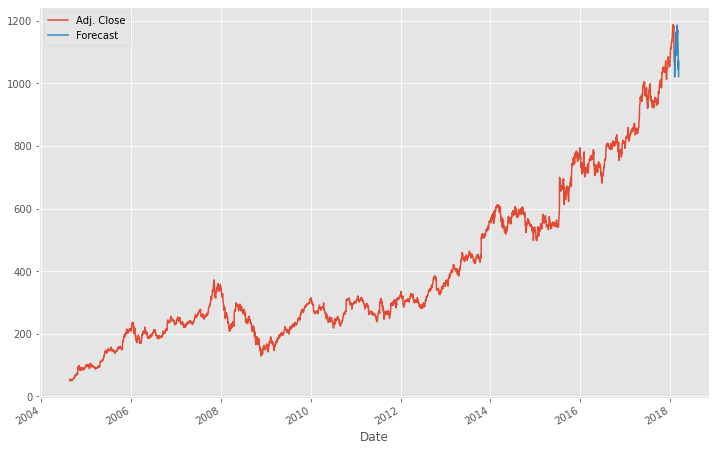

In [42]:
df[['Adj. Close', 'Forecast']].plot(figsize=(12, 8))

**Pickling and Scaling**

Pickle is serialzation of any python object like dict or classifier. We use it to save a classifier to avoid training step.

In [43]:
pickle_in = open('linearregression.pickle','rb')

In [44]:
clf = pickle.load(pickle_in)

In [45]:
clf.score(X_test, y_test) # still works

0.9776696547392425

**Writing linear regression algorithm**

Linear regression needs to have relationship between y and x axis, if there is no clear relation ship between them, it will be hard to find the best fit line between them, so linear regression will not be very beneficial there. For example if both y and x values are getting higher with each data point, we can clearly see that there is relationship between them.

y = mx + b, we usually have x values so we can plug it right in, but we do not have m or b values. Whate are they?

m = slope of the line, b = y intercept                           

m = (mean(x) * mean(y) - mean(xy)) / (mean(x)^2 - mean(x^2))
b = mean(y) - m*mean(x)

y = (mean(x) * mean(y) - mean(xy)) / (mean(x)^2 - mean(x^2)) * x + mean(y) - m*mean(x)

It works on 2d data.